In [ ]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import sys
from time import time

%matplotlib inline

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

from PennFudanDataset import PennFudanDataset

In [ ]:
base_dir = os.path.abspath('../../_data')
data_dir = os.path.join(base_dir, 'PennFudanPed')

### An Instance segmentation model for PennFudan Dataset

In [ ]:
def get_instance_segmentation_model(num_classes):
    # load a pre-trained model on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replaces the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # get the number of features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layers = 256
    # replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, dim_reduced=hidden_layers, num_classes=num_classes)
    
    return model

## Training and evaluation functions

### - Transform

In [ ]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    
    return T.Compose(transforms)

### - Loading Data

In [ ]:
# load dataset and defined transforms
dataset = PennFudanDataset(data_dir, transforms=get_transform(train=True))
dataset_test = PennFudanDataset(data_dir, transforms=get_transform(train=False))

In [ ]:
# split data into train and test sets
torch.manual_seed(7)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])            # 120 instances
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])  # 50 instances

In [ ]:
# define training and validation dataloaders
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=2,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test,
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=4,
                                               collate_fn=utils.collate_fn)

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
# our dataset has two classes only - background and person
num_classes = 2

# get the model
model = get_instance_segmentation_model(num_classes)
model = model.to(device)

In [ ]:
# construct the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
                            lr=0.005,
                            momentum=0.9,
                            weight_decay=0.0005)

# learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [23]:
start = time()
num_ephocs = 10

for epoch in range(num_ephocs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device)
    
end = time() - start

Epoch: [0]  [ 0/60]  eta: 0:02:05  lr: 0.000090  loss: 4.6682 (4.6682)  loss_classifier: 0.6654 (0.6654)  loss_box_reg: 0.3303 (0.3303)  loss_mask: 3.6179 (3.6179)  loss_objectness: 0.0416 (0.0416)  loss_rpn_box_reg: 0.0129 (0.0129)  time: 2.0981  data: 0.6132  max mem: 2480
Epoch: [0]  [10/60]  eta: 0:00:25  lr: 0.000936  loss: 1.7610 (2.5568)  loss_classifier: 0.4433 (0.4240)  loss_box_reg: 0.2089 (0.2144)  loss_mask: 1.1244 (1.8896)  loss_objectness: 0.0157 (0.0182)  loss_rpn_box_reg: 0.0090 (0.0107)  time: 0.5111  data: 0.0586  max mem: 3029
Epoch: [0]  [20/60]  eta: 0:00:17  lr: 0.001783  loss: 0.7725 (1.6652)  loss_classifier: 0.2244 (0.3090)  loss_box_reg: 0.1910 (0.2132)  loss_mask: 0.3500 (1.1077)  loss_objectness: 0.0166 (0.0230)  loss_rpn_box_reg: 0.0113 (0.0122)  time: 0.3622  data: 0.0044  max mem: 3029
Epoch: [0]  [30/60]  eta: 0:00:12  lr: 0.002629  loss: 0.5016 (1.2673)  loss_classifier: 0.0813 (0.2306)  loss_box_reg: 0.1478 (0.1827)  loss_mask: 0.2170 (0.8239)  loss_ob

In [24]:
# training time in seconds
end

308.004355430603

Now that training has finished, let's have a look at what it actually predicts in a test image

In [ ]:
img, _ = dataset_test[1]
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])    # is a list of dictionaries

In [40]:
# first dim is the number of identified pedestrians
prediction[0]['masks'].shape

torch.Size([6, 1, 379, 767])

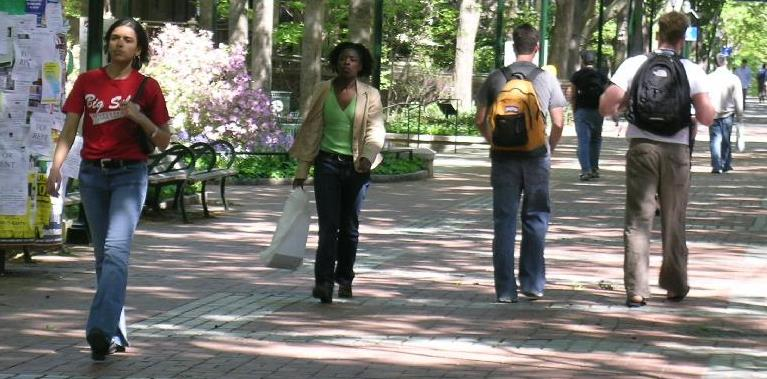

In [39]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())